# Baseline Gender Bias Document Classifiers

* **Supervised learning**
    * Train, Validate, and (Blind) Test Data: under directory `clf_data/`
* **Multilabel classification**
    * 3 categories of labels:
        1. *Person Name:* Unknown, Non-binary, Feminine, Masculine
        2. *Linguistic:* Generalization, Gendered Pronoun, Gendered Role
        3. *Contextual:* Empowering, Occupation, Omission, Stereotype

***

**Table of Contents**

[Setup](#set)

Baseline Classifiers:

  * [Classifier 1: Multinomial Naive Bayes](#mnb) - worst-performing

  * [Classifier 2: Logistic Regression](#log) - top-performing

  * [Classifier 3: Random Forest](#ran)
  
[Error Analysis](#err)

***

<a id="set"></a>
## Setup

In [1]:
# For custom functions
import utils

# For working with data files and directories
import numpy as np
import pandas as pd
from pathlib import Path

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For classification with scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_text
# from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

Read in the training, validation, (a.k.a. development or devtest) and blind test data:

In [2]:
datadir = "data/aggregated_data/"
X_train_path = datadir+"train_docs.txt"
X_devtest_path = datadir+"validate_docs.txt"
y_train_path = datadir+"train_labels.txt"
y_devtest_path = datadir+"validate_labels.txt"

In [3]:
docs_seperator = "\n|\n"
labels_seperator = "\n"

In [4]:
X_train = utils.readData(X_train_path, docs_seperator)
print(X_train[0])
print(len(X_train))

Angus McIntosh was born to Scottish parents near Sunderland, County Durham, on 10 January 1914. He was educated at Ryhope Grammar School, then at Oriel College Oxford where in 1934 he graduated with first class honours in English language and literature. Between 1936 and 1938 he was at Harvard and on his return to Britain he became a Lecturer at the Department of English, University College Swansea. During the Second World War, McIntosh initially served with the Tank Corps then as a Major in Military Intelligence during which time he was posted to Bletchley where he participated in the decrypting of German military communication Enigma codes. After the war he took up a lectureship at Christ Church Oxford and then in 1948 he was appointed first Forbes Professor of English Language and General Linguistics at Edinburgh University. At Edinburgh, he was the prime mover in the founding of the School of Epistemics - now Informatics - and the School of Scottish Studies, of the then separate De

In [5]:
X_devtest = utils.readData(X_devtest_path, docs_seperator)
print(X_devtest[0])
print(len(X_devtest))

Charles Hedges was born in either 1649 or 1650. he was educated at Magdalen, Oxford, where he took a B.A. in 1670, an M.A. in 1673, and a D.C.L in 1675. In his last year of study he was admitted to the Society of Advocates, and by 1686 he was Chancellor and Vicar-General of the Diocese of Rochester. In 1689 he was created Master of the Faculties and Judge of the Admiralty Court. Hedges was also knighted on 4 June 1689. From 1698 he contested various constituencies for a seat in Parliament including Orford in Suffolk, Dover, Calne and Malmesbury, West Looe, and East Looe. In 1700 he became a Secretary of State and Privy Councillor with the help of the Earl of Rochester (1641-1711). For some time Sir Charles Hedges resided at Richmond Green, but in 1700 he bought an estate in Compton Bassett, near Calne in Wiltshire. Hedges died on 10 June 1714. The background to the collection item, from Hedges as Secretary of State, to the Lord Lieutenant of Ireland, is the Aliens Act of 1705 which sta

In [6]:
y_train = utils.readData(y_train_path, labels_seperator)
print(y_train[:3])
print(len(y_train))

['Occupation, Stereotype, Masculine, Gendered-Pronoun'
 'Gendered-Pronoun, Stereotype, Unknown, Masculine, Omission, Generalization, Gendered-Role, Occupation'
 'Gendered-Pronoun, Stereotype, Unknown, Masculine, Omission, Occupation']
1111


In [7]:
y_devtest = utils.readData(y_devtest_path, labels_seperator)
print(y_devtest[0])
print(len(y_devtest))

Gendered-Pronoun, Stereotype, Masculine, Omission, Gendered-Role, Generalization, Occupation
371


Convert the data to numeric representations, where:
```
labels = {
    "Unknown": 0, "Non-binary": 1, "Feminine": 2, "Masculine": 3,
    "Generalization": 4, "Gendered-Pronoun": 5, "Gendered-Role": 6,
    "Occupation": 7, "Omission":8, "Stereotype": 9, "Empowering": 10
         }
```

In [8]:
# Convert the strings of labels to tuples of numbers
y_train_numeric = utils.getNumericLabels(y_train)
y_devtest_numeric = utils.getNumericLabels(y_devtest)
# y_blindtest_numeric = utils.getNumericLabels(y_blindtest)
assert len(y_train_numeric) == len(y_train)
assert len(y_devtest_numeric) == len(y_devtest)
# assert len(y_blindtest_numeric) == len(y_blindtest)

Binarize the data so labels are represented by a 0 (not present) or 1 (present):

In [9]:
# Convert each iterable of iterables above to a multilabel format
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train_numeric)
y_devtest_binarized = mlb.fit_transform(y_devtest_numeric)
print(y_devtest_binarized.shape)
print(y_devtest_binarized[0])

(371, 9)
[0 0 1 1 1 1 1 1 1]


In [ ]:
# # Bag of Words
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# X_test_counts = count_vect.fit_transform(X_test)
# print("Bag of Words:")
# print(X_train_counts.shape)
# print(X_test_counts.shape)

# # Term Frequency times Inverse Document Frequency
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
# print("TFIDF:")
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

In [ ]:
# assert X_train_counts.shape[0] == len(y_train_numeric)
# assert X_test_tfidf.shape[0] == len(y_test_numeric)

Create the directory to write the classification models' performance metrics to:

In [10]:
metrics_dir = "./baseline_performance_metrics/"
Path(metrics_dir).mkdir(parents=True, exist_ok=True)

## Baseline Classifiers
<a id="mnb"></a>
### Classifier 1: Multinomial Naive Bayes

Build a pipeline:

In [11]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(MultinomialNB()))
    ])

In [12]:
clf_pipeline.fit(X_train, y_train_binarized)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [13]:
predicted_dev = clf_pipeline.predict(X_devtest)

### Peformance

Calculate performance metrics for the Multinomial Naive Bayes classifier

In [14]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.9769392033542977


In [15]:
classes = clf_pipeline.classes_
print(classes)
original_classes = mlb.classes_
print(original_classes)

[0 1 2 3 4 5 6 7 8]
[0 2 3 4 5 6 7 8 9]


Plot a [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix) of the results, where, for class *i*:
* Count of true negatives (TN) is at position *i*,0,0
* Count of false negatives (FN) is at position *i*,1,0
* Count of true positives (FP) is at position *i*,1,1
* Count of false positives (PF) is at position *i*,0,1

In [16]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,365,6,0.983827,1.000000,0.991848
1,Feminine,367,4,0,0,0.000000,0.000000,0.000000
2,Masculine,348,5,18,0,1.000000,0.782609,0.878049
3,Generalization,357,8,3,3,0.500000,0.272727,0.352941
4,Gendered-Pronoun,352,1,18,0,1.000000,0.947368,0.972973
5,Gendered-Role,357,13,1,0,1.000000,0.071429,0.133333
6,Occupation,346,6,17,2,0.894737,0.739130,0.809524
7,Omission,354,16,1,0,1.000000,0.058824,0.111111
8,Stereotype,358,13,0,0,0.000000,0.000000,0.000000


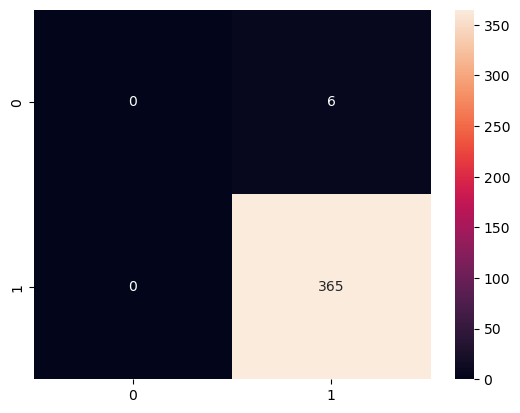

In [17]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

In [18]:
df_dev.to_csv(metrics_dir+"MultinomialNB_dev_performance.csv")

<a id="log"></a>
### Classifier 2: Logistic Regression

*a.k.a. maximum-entropy (MaxEnt) or log-linear classification*

In [19]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr")))
    ])

In [20]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)

### Performance

Calculate performance metrics for the Logistic Regression classifier

In [21]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.9841269841269841


In [22]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [23]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)

In [24]:
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,365,6,0.983827,1.000000,0.991848
1,Feminine,367,4,0,0,0.000000,0.000000,0.000000
2,Masculine,348,5,18,0,1.000000,0.782609,0.878049
3,Generalization,356,1,10,4,0.714286,0.909091,0.800000
4,Gendered-Pronoun,352,1,18,0,1.000000,0.947368,0.972973
5,Gendered-Role,355,5,9,2,0.818182,0.642857,0.720000
6,Occupation,347,5,18,1,0.947368,0.782609,0.857143
7,Omission,351,10,7,3,0.700000,0.411765,0.518519
8,Stereotype,356,4,9,2,0.818182,0.692308,0.750000


In [51]:
# df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
# df_test

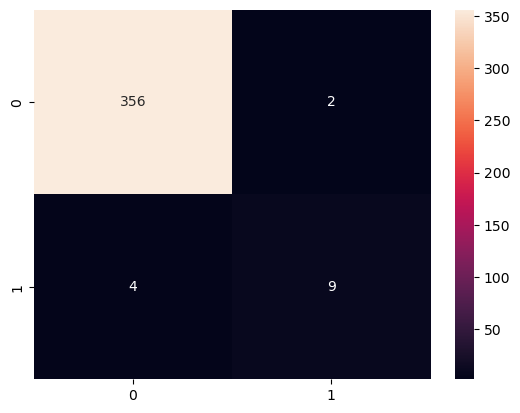

In [25]:
ax = sns.heatmap(dev_matrix[8], annot=True, fmt="d")

This classifier performs better than the first classifier (Multinomial Naive Bayes) and third classifier (Random Forest).

In [26]:
df_dev.to_csv(metrics_dir+"LogisticRegression_dev_performance.csv")

<a id="ran"></a>
### Classifier 3: Random Forest

In [27]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(RandomForestClassifier(max_depth=3, random_state=0)))
    ])

In [28]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)

In [29]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [30]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.9772386942198263


In [31]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,365,6,0.983827,1.000000,0.991848
1,Feminine,367,4,0,0,0.000000,0.000000,0.000000
2,Masculine,348,10,13,0,1.000000,0.565217,0.722222
3,Generalization,357,5,6,3,0.666667,0.545455,0.600000
4,Gendered-Pronoun,352,6,13,0,1.000000,0.684211,0.812500
5,Gendered-Role,357,12,2,0,1.000000,0.142857,0.250000
6,Occupation,348,10,13,0,1.000000,0.565217,0.722222
7,Omission,354,14,3,0,1.000000,0.176471,0.300000
8,Stereotype,358,6,7,0,1.000000,0.538462,0.700000


In [32]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)

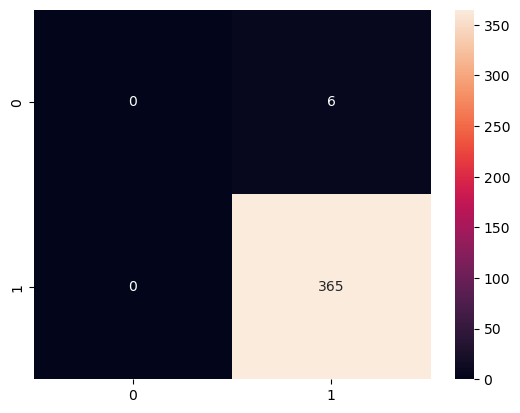

In [33]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

This classifier performs better than Multinomial Naive Bayes and worse than Logistic Regression.

In [34]:
df_dev.to_csv(metrics_dir+"RandomForest_dev_performance.csv")

<a id="err"></a>
## Error Analysis

Error analysis of the **Logistic Regression** classifier, as this is the top-performing baseline classification model.

In [59]:
# Associate classes to numeric labels to strings of label names
label_class_to_no = dict(zip(classes,original_classes))
labels = {
    "Unknown": 0, "Non-binary": 1, "Feminine": 2, "Masculine": 3,
    "Generalization": 4, "Gendered-Pronoun": 5, "Gendered-Role": 6,
    "Occupation": 7, "Omission":8, "Stereotype": 9, "Empowering": 10
         }
label_no_to_name = dict(zip(list(labels.values()), list(labels.keys())))

#### Dev Data Confusion Matrices

In [60]:
matrices = dict()  # keys are labels, values are 2D arrays 
for col in range(len(classes)):
    y_test_label = y_devtest_binarized[:, col]
    pred_label = predicted_dev[:, col]
    
    matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

In [61]:
png_dir = metrics_dir+"logreg_dev_confusion_matrices/"
Path(png_dir).mkdir(parents=True, exist_ok=True)

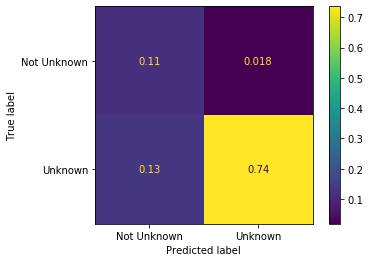

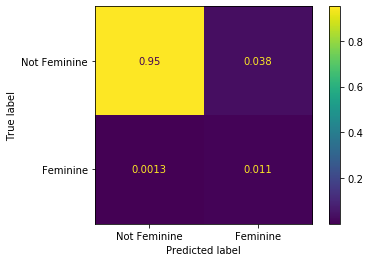

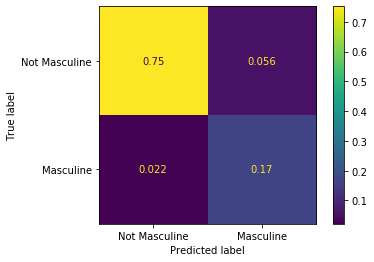

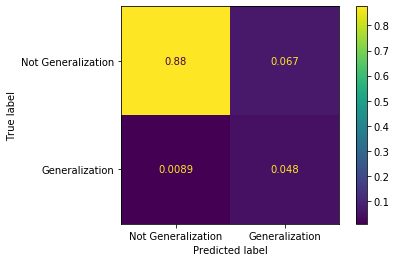

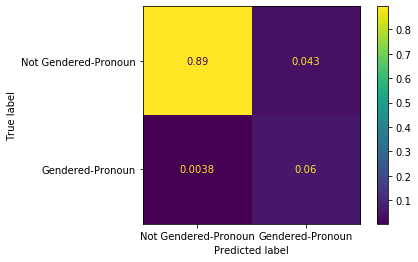

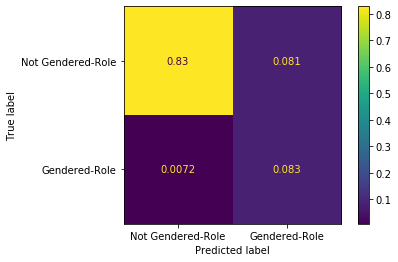

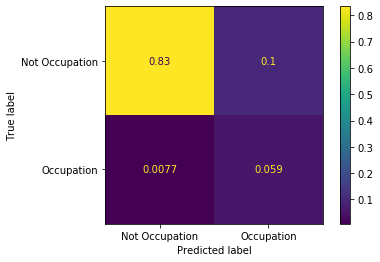

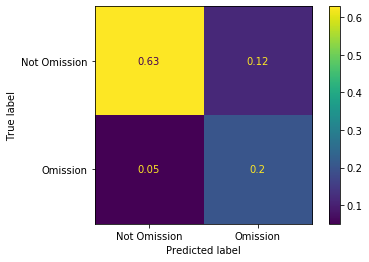

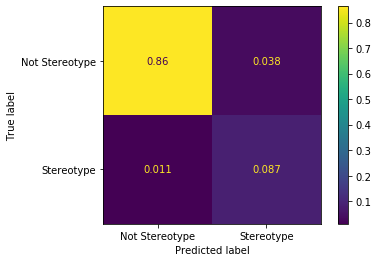

In [62]:
for label_class,matrix in matrices.items():
    label_name = label_no_to_name[label_class_to_no[label_class]]
    filename = "{}_cmatrix_normalized_all.png".format(label_name)
    ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
    plt.savefig(png_dir+filename)

Convert predicted dev labels back to text:

In [64]:
predicted_dev[0] # array([1, 0, 1, 0, 1, 1, 1, 0, 1])

array([1, 0, 1, 0, 1, 1, 1, 0, 1])

In [65]:
X_devtest[0]

"Peter Baillie ( 1889-1914), youngest brother to John Baillie and Donald Macpherson Baillie, was educated at Inverness Royal Academy and then at George Watson's College. Entering Edinburgh University in 1907, he graduated with a M.B., Ch.B. in 1912. For many years he was a member of the Philomathic Society and became its President in 1911. He was senior house surgeon at Mildmay Mission Hospital, London, for six months and in January 1914 he left Britain for Jalna, India, taking up a post to which he had been appointed by the Foreign Mission Committee of the United Free Church. He was ordained as a missionary elder of Langside Hill United Free Church, Glasgow, prior to his departure. While in India he was the victim of a drowning at Mahableshwar."

#### Blind Test Data Confusion Matrices

In [ ]:
# matrices = dict()  # keys are labels, values are 2D arrays 
# for col in range(len(classes)):
#     y_test_label = y_blindtest_binarized[:, col]
#     pred_label = predicted_test[:, col]
    
#     matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

In [ ]:
# png_dir = metrics_dir+"logreg_test_confusion_matrices/"
# Path(png_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
# for label_class,matrix in matrices.items():
#     label_name = label_no_to_name[label_class_to_no[label_class]]
#     filename = "{}_cmatrix_normalized_all.png".format(label_name)
#     ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
#     plt.savefig(png_dir+filename)

In [ ]:
# y_devtest_binarized

In [ ]:
# classes = clf_pipeline.classes_
# original_classes = mlb.classes_
# print("Clf Classes:", classes)
# print("Original Classes:", original_classes)